In [1]:
import os
os.chdir('/data/l989o/deployed/a')
import sys
if '/data/l989o/a' in sys.path:
    sys.path.remove('/data/l989o/a')
print(os.getcwd())
from jupy import *

/data/l989o/deployed/a


In [2]:
from data import RawMeanDataset
import torch
import matplotlib.pyplot as plt
params = {"ytick.color" : "k",
          "xtick.color" : "k",
          'text.color' : 'k',
          "axes.labelcolor" : "k",
          "axes.edgecolor" : "k"}
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams.update(params)

True
<KeysViewHDF5 ['count', 'maximum', 'mean', 'sum', 'variance']>


In [3]:
from tqdm import tqdm
import torch
from data import TransformedMeanDataset
ds = TransformedMeanDataset('train')

list_of_t = []
for t in tqdm(ds):
    list_of_t.append(t)
tt = torch.cat(list_of_t, dim=0)
print(tt.shape)

means = torch.mean(tt, dim=0)

100%|██████████| 389/389 [00:29<00:00, 13.06it/s]

torch.Size([762354, 39])


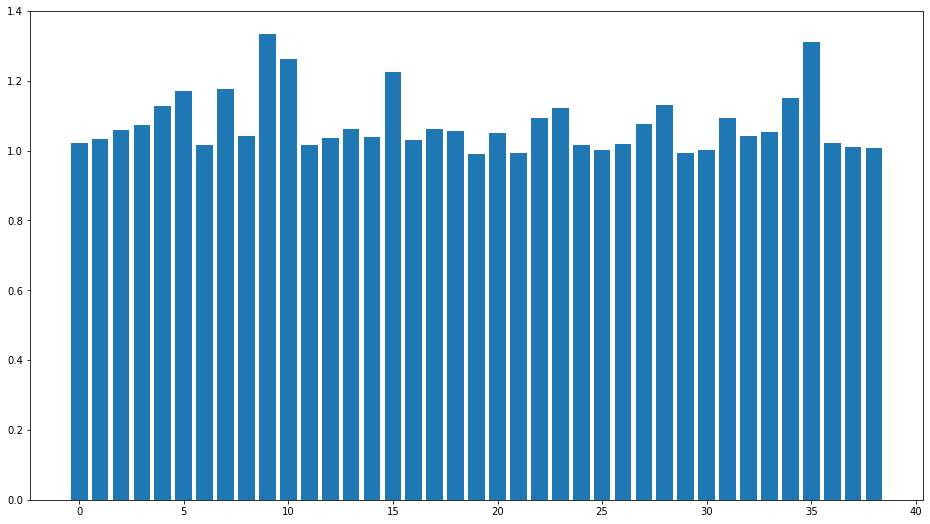

In [4]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 9))
plt.bar(list(range(39)), means.numpy())
plt.show()

In [5]:
# from sklearn.preprocessing import StandardScaler
# from tqdm import tqdm
# ds = RawMeanDataset('train', filter_by_area=True)
# scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
# l = []
# cells = []
# for x in tqdm(ds):
#     xx = torch.mean(x, dim=0).view(1, -1)
#     l.append(xx)
#     cells.append(x.shape[0])
#     # scaler.partial_fit(xx)
# x = torch.cat(l, dim=0)
# x = torch.asinh(x)
# mu1 = torch.from_numpy(scaler.mean_).float()
# std1 = torch.from_numpy(scaler.var_).float().sqrt()
# x1 = (x - mu1) / std1

In [6]:
from data import OmeDataset
ome_ds = OmeDataset('train')

In [7]:
def colorize_masks(ome_index, ome_filename, channel_expression, masks, split):
    def get_filtered_labels_mapping(ome_index, ome_filename, split):
        import pickle
        f = os.path.join('data/spatial_uzh_processed/a', f'ok_cells_{split}.npy')
        d = pickle.load(open(f, 'rb'))
        list_of_cells = d['list_of_cells']
        list_of_ome_filenames = d['list_of_ome_filenames']
        list_of_ome_indices = d['list_of_ome_indices']
        list_of_cell_ids = d['list_of_cell_ids']
        cell_is_ok = d['cell_is_ok']
        begin = list_of_ome_filenames.index(ome_filename)
        end = len(list_of_ome_filenames) - list_of_ome_filenames[::-1].index(ome_filename)
        # print(list_of_ome_filenames[begin])
        # print(list_of_ome_filenames[end - 1])
        # print(list_of_ome_filenames[end])
        # print(list_of_ome_filenames[end + 1])
        oks = cell_is_ok[begin: end]
        # labels = list_of_cell_ids[begin: end]
        # print(oks.shape)
        # print(t.shape)
        l0 = np.array(list(range(np.sum(oks).item())))
        l1 = list_of_cell_ids[ome_index][oks]
        assert len(l0) == len(l1)
        d = dict(zip(l0, l1))
        return d
    # from data import get_filtered_labels_mapping
    d = get_filtered_labels_mapping(ome_index, ome_filename, split)
    new_masks = np.zeros((masks.shape[0], masks.shape[1], 4))
    omitted_labels = set(list(range(np.max(masks)))).difference([dd.item() for dd in d.values()]).difference({0})
    for l in omitted_labels:
        new_masks[masks == l, :] = (1., 0., 0., 1.)
    new_masks[masks == 0, :] = (0., 0., 0., 1.)
    for k, v in d.items():
        a = torch.min(channel_expression)
        b = torch.max(channel_expression)
        e = channel_expression[k].item()
        normalized_expression = (e - a) / (b - a)
        import matplotlib

        cmap = matplotlib.cm.get_cmap('viridis')
        ee = cmap(normalized_expression.item())
        new_masks[masks == v.item(), :] = ee
    return new_masks

In [ ]:
def a(split, channel):
    # plt.figure(figsize=(4, 2))
    cols = 5
    rows = 1
    aa = 2
    d_cols = aa
    d_rows = aa * 16 / 9
    n = cols * rows

    from data import MasksDataset
    masks_dataset = MasksDataset(split)

    fig = plt.figure(figsize=(cols * d_cols * 2, rows * d_rows), dpi=72)
    from data import OmeDataset
    n = min(len(ds) - 1, n)
    np.random.seed(100)
    r = np.random.choice(len(ds) - 1, n, replace=False)
    from data import CHANNEL_NAMES
    for k in range(n):
        ax = plt.subplot(rows, cols, k + 1)
        ome_index = r[k - 1]
        # ome = ds[ome_index][:, :, channel].numpy()
        # ome = np.log(ome + 1)
        o = ds.filenames[ome_index]
        channel_expression = ds[ome_index][:, channel]
        masks = masks_dataset[ome_index]
        colorized_masks = colorize_masks(ome_index, o, channel_expression, masks, split)
        plt.imshow(colorized_masks)
        # ax = plt.subplot(rows, 2 * cols, 2 * k + 2)
        # plt.imshow(ome)
        plt.xlabel('pixels')
        plt.ylabel('pixels')
        plt.title(f'ome_index = {ome_index}')
        plt.suptitle(f'channel = {channel}')
        # plt.colorbar(ax=ax, orientation='horizontal')
        name = CHANNEL_NAMES[channel]
        # ax.set_title(f'channel = {channel} ({name}), random {split} image')

    # fig.suptitle('Distribution of the number of transcripts per cells across batches (plots) and patients (colors)')
    plt.tight_layout()
    fig.show()

def b(split, channel):
    # plt.figure(figsize=(4, 2))
    cols = 5
    rows = 1
    aa = 2
    d_cols = aa
    d_rows = aa * 16 / 9
    n = cols * rows

    from data import MasksDataset
    masks_dataset = MasksDataset(split)

    fig = plt.figure(figsize=(cols * d_cols * 2, rows * d_rows), dpi=72)
    from data import OmeDataset
    n = min(len(ds) - 1, n)
    np.random.seed(100)
    r = np.random.choice(len(ds) - 1, n, replace=False)
    from data import CHANNEL_NAMES
    for k in range(n):
        ax = plt.subplot(rows, cols, k + 1)
        ome_index = r[k - 1]
        ome = np.arcsinh(ome_ds[ome_index])
        plt.imshow(ome[:, :, channel])
        plt.xlabel('pixels')
        plt.ylabel('pixels')
        plt.title(f'ome_index = {ome_index}')
        plt.suptitle(f'channel = {channel}')
        # plt.colorbar(ax=ax, orientation='horizontal')
        name = CHANNEL_NAMES[channel]
        # ax.set_title(f'channel = {channel} ({name}), random {split} image')

    # fig.suptitle('Distribution of the number of transcripts per cells across batches (plots) and patients (colors)')
    plt.tight_layout()
    fig.show()


b('train', 0)
a('train', 0)
print()
b('train', 10)
a('train', 10)
print()
b('train', 20)
a('train', 20)

In [8]:
# plt.figure(figsize=(40, 40))
# im = np.arcsinh(ome_ds[98][:, :, 20])
# plt.imshow(im)
# plt.show()

saving figure in data/spatial_uzh_processed/a/before_after_asinh.png


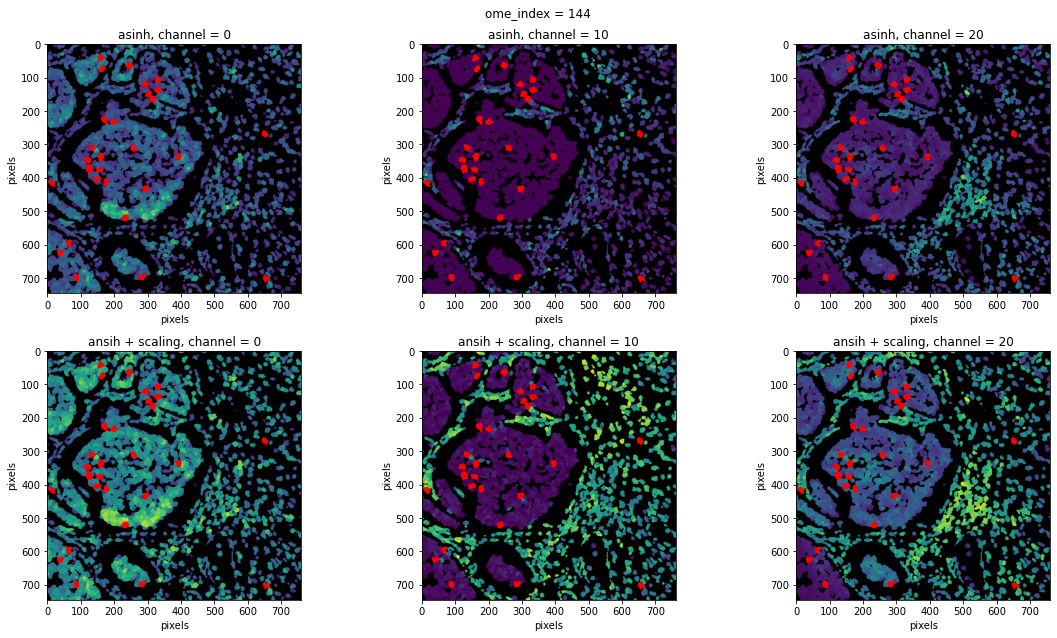

In [8]:
ome_index = 144
channels = [0, 10, 20]
split = 'train'
from data import MasksDataset
masks_dataset = MasksDataset(split)
raw_mean_ds = RawMeanDataset(split)

fig, axes = plt.subplots(2, 3, figsize=(16, 9))
axes = axes.T.flatten()
j_ax = 0
def next_ax():
    global j_ax
    ax = axes[j_ax]
    j_ax += 1
    return ax
for channel in channels:
    ax = next_ax()
    # ome = np.arcsinh(ome_ds[ome_index])
    # ax.imshow(ome[:, :, channel])
    o = ds.filenames[ome_index]
    channel_expression = raw_mean_ds[ome_index][:, channel]
    masks = masks_dataset[ome_index]
    colorized_masks = colorize_masks(ome_index, o, channel_expression, masks, split)
    ax.imshow(colorized_masks)
    ax.set_xlabel('pixels')
    ax.set_ylabel('pixels')
    ax.set_title(f'asinh, channel = {channel}')

    ax = next_ax()
    o = ds.filenames[ome_index]
    channel_expression = ds[ome_index][:, channel]
    masks = masks_dataset[ome_index]
    colorized_masks = colorize_masks(ome_index, o, channel_expression, masks, split)
    ax.imshow(colorized_masks)
    ax.set_xlabel('pixels')
    ax.set_ylabel('pixels')
    ax.set_title(f'ansih + scaling, channel = {channel}')

plt.suptitle(f'ome_index = {ome_index}')
plt.tight_layout()
plt_show(plt, 'before_after_asinh.png')

100%|██████████| 3/3 [00:00<00:00,  4.82it/s]


saving figure in data/spatial_uzh_processed/a/before_after_hist.png


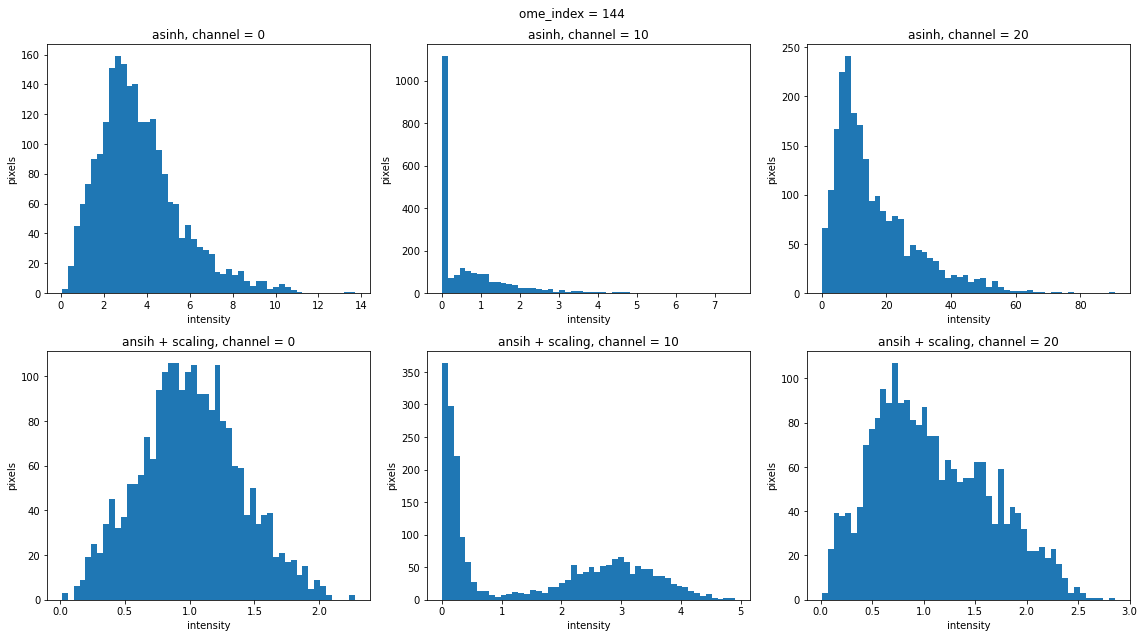

In [12]:
ome_index = 144
channels = [0, 10, 20]
split = 'train'
from data import MasksDataset
masks_dataset = MasksDataset(split)
raw_mean_ds = RawMeanDataset(split)

fig, axes = plt.subplots(2, 3, figsize=(16, 9))
axes = axes.T.flatten()
j_ax = 0
def next_ax():
    global j_ax
    ax = axes[j_ax]
    j_ax += 1
    return ax
for channel in tqdm(channels):
    ax = next_ax()
    # ome = np.arcsinh(ome_ds[ome_index])
    # ax.imshow(ome[:, :, channel])
    o = ds.filenames[ome_index]
    channel_expression = raw_mean_ds[ome_index][:, channel]
    # masks = masks_dataset[ome_index]
    # colorized_masks = colorize_masks(ome_index, o, channel_expression, masks, split)
    # ax.imshow(colorized_masks)
    ax.hist(channel_expression.numpy(), bins=50)
    ax.set_xlabel('intensity')
    ax.set_ylabel('pixels')
    ax.set_title(f'asinh, channel = {channel}')

    ax = next_ax()
    o = ds.filenames[ome_index]
    channel_expression = ds[ome_index][:, channel]
    # masks = masks_dataset[ome_index]
    # colorized_masks = colorize_masks(ome_index, o, channel_expression, masks, split)
    # ax.imshow(colorized_masks)
    ax.hist(channel_expression.numpy(), bins=50)
    ax.set_xlabel('intensity')
    ax.set_ylabel('pixels')
    ax.set_title(f'ansih + scaling, channel = {channel}')

plt.suptitle(f'ome_index = {ome_index}')
plt.tight_layout()
plt_show(plt, 'before_after_hist.png')